# Ray et al 2013 Extract-Transform-Load
**Authorship:**
Adam Klie (last updated: *06/08/2023*)
***
**Description:**
Notebook to extract, transform, and load (ETL) data from the Ray et al (2013) dataset.
***

In [2]:
# General imports
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# EUGENe imports
import eugene as eu
from eugene import preprocess as pp
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/ray13"

# EUGENe packages
import seqdatasets
import seqdata as sd
import seqpro as sp

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Xarray version: {xr.__version__}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqDatasets version: {seqdatasets.__version__}")
print(f"SeqData version: {sd.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Pandas version: 1.5.2
Xarray version: 2023.4.0
Eugene version: 0.0.8
SeqDatasets version: 0.0.1
SeqData version: 0.0.1


# Download and load in the dataset to a raw `SeqData` object

In [3]:
# Load in the downloaded data, or download it if it's not there
sdata = sd.open_zarr(os.path.join(settings.dataset_dir, "ray13_norm.zarr"))

In [ ]:
# Load auxiliary data as well
# wget https://hugheslab.ccbr.utoronto.ca/supplementary-data/RNAcompete_eukarya/z_scores.txt.gz -O /cellar/users/aklie/data/eugene/revision/ray13/z_scores.txt.gz
# wget https://hugheslab.ccbr.utoronto.ca/supplementary-data/RNAcompete_eukarya/e_scores.txt.gz -O /cellar/users/aklie/data/eugene/revision/ray13/e_scores.txt.gz
# wget https://hugheslab.ccbr.utoronto.ca/supplementary-data/RNAcompete_eukarya/hg19_motif_hits.tar.gz -O /cellar/users/aklie/data/eugene/revision/ray13/hg19_motif_hits.tar.gz
# tar -xvzf cellar/users/aklie/data/eugene/revision/ray13/hg19_motif_hits.tar.gz -C /cellar/users/aklie/data/eugene/revision/ray13/
# wget https://static-content.springer.com/esm/art%3A10.1038%2Fnbt.3300/MediaObjects/41587_2015_BFnbt3300_MOESM53_ESM.xlsx -O /cellar/users/aklie/data/eugene/revision/ray13/41587_2015_BFnbt3300_MOESM53_ESM.xlsx

In [5]:
# Get a list of only the target columns
column_keys = pd.Index(sdata.data_vars.keys())
target_mask = column_keys.str.contains("RNCMPT")
target_cols = column_keys[target_mask]
random_idxs = np.random.choice(np.arange(len(target_cols)), size=9, replace=False)
random_cols = target_cols[random_idxs]
len(target_cols)

244

In [71]:
# Subset to set type (A -- training or B -- testing)
sdata_setA = sdata.sel(_sequence=sdata["Probe_Set"].compute() == "SetA")
sdata_setB = sdata.sel(_sequence=sdata["Probe_Set"].compute() == "SetB")

# Preprocess the training set

## Preprocess the seqs
- Padded elements of sequences are replaced with a one hot encoded value of 0.25 spanning each base.

In [73]:
print(f"Max seq len: {np.max(sp.length(sdata['seq'].values))}")

Max seq len: 41


In [67]:
# Pad sequences to max length with Ns
pad_seqs_sdata(sdata_setA, length=41, seq_key="seq", pad="both", pad_value="N")
pad_seqs_sdata(sdata_setB, length=41, seq_key="seq", pad="both", pad_value="N")

In [68]:
# One-hot encode sequences and add fill value
ohe_seqs_sdata(sdata_setA, alphabet="RNA", seq_key="seq_padded", fill_value=0.25)
ohe_seqs_sdata(sdata_setB, alphabet="RNA", seq_key="seq_padded", fill_value=0.25)

here


## Preprocess the targets
- The values of probe intensities are clamped at 99.95% percentile per binding protein to eliminate outliers and balance the data.
- The probe intensities are normalized to a mean of 0 and a standard deviation of 1.

In [75]:
# Split only those training sequences in SetA into train and validation sets
pp.train_test_split_sdata(sdata_setA, id_var="Probe_ID", test_size=0.2)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 6801 times more chunks
  return self.array[key]
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 1698 times more chunks
  return self.array[key]


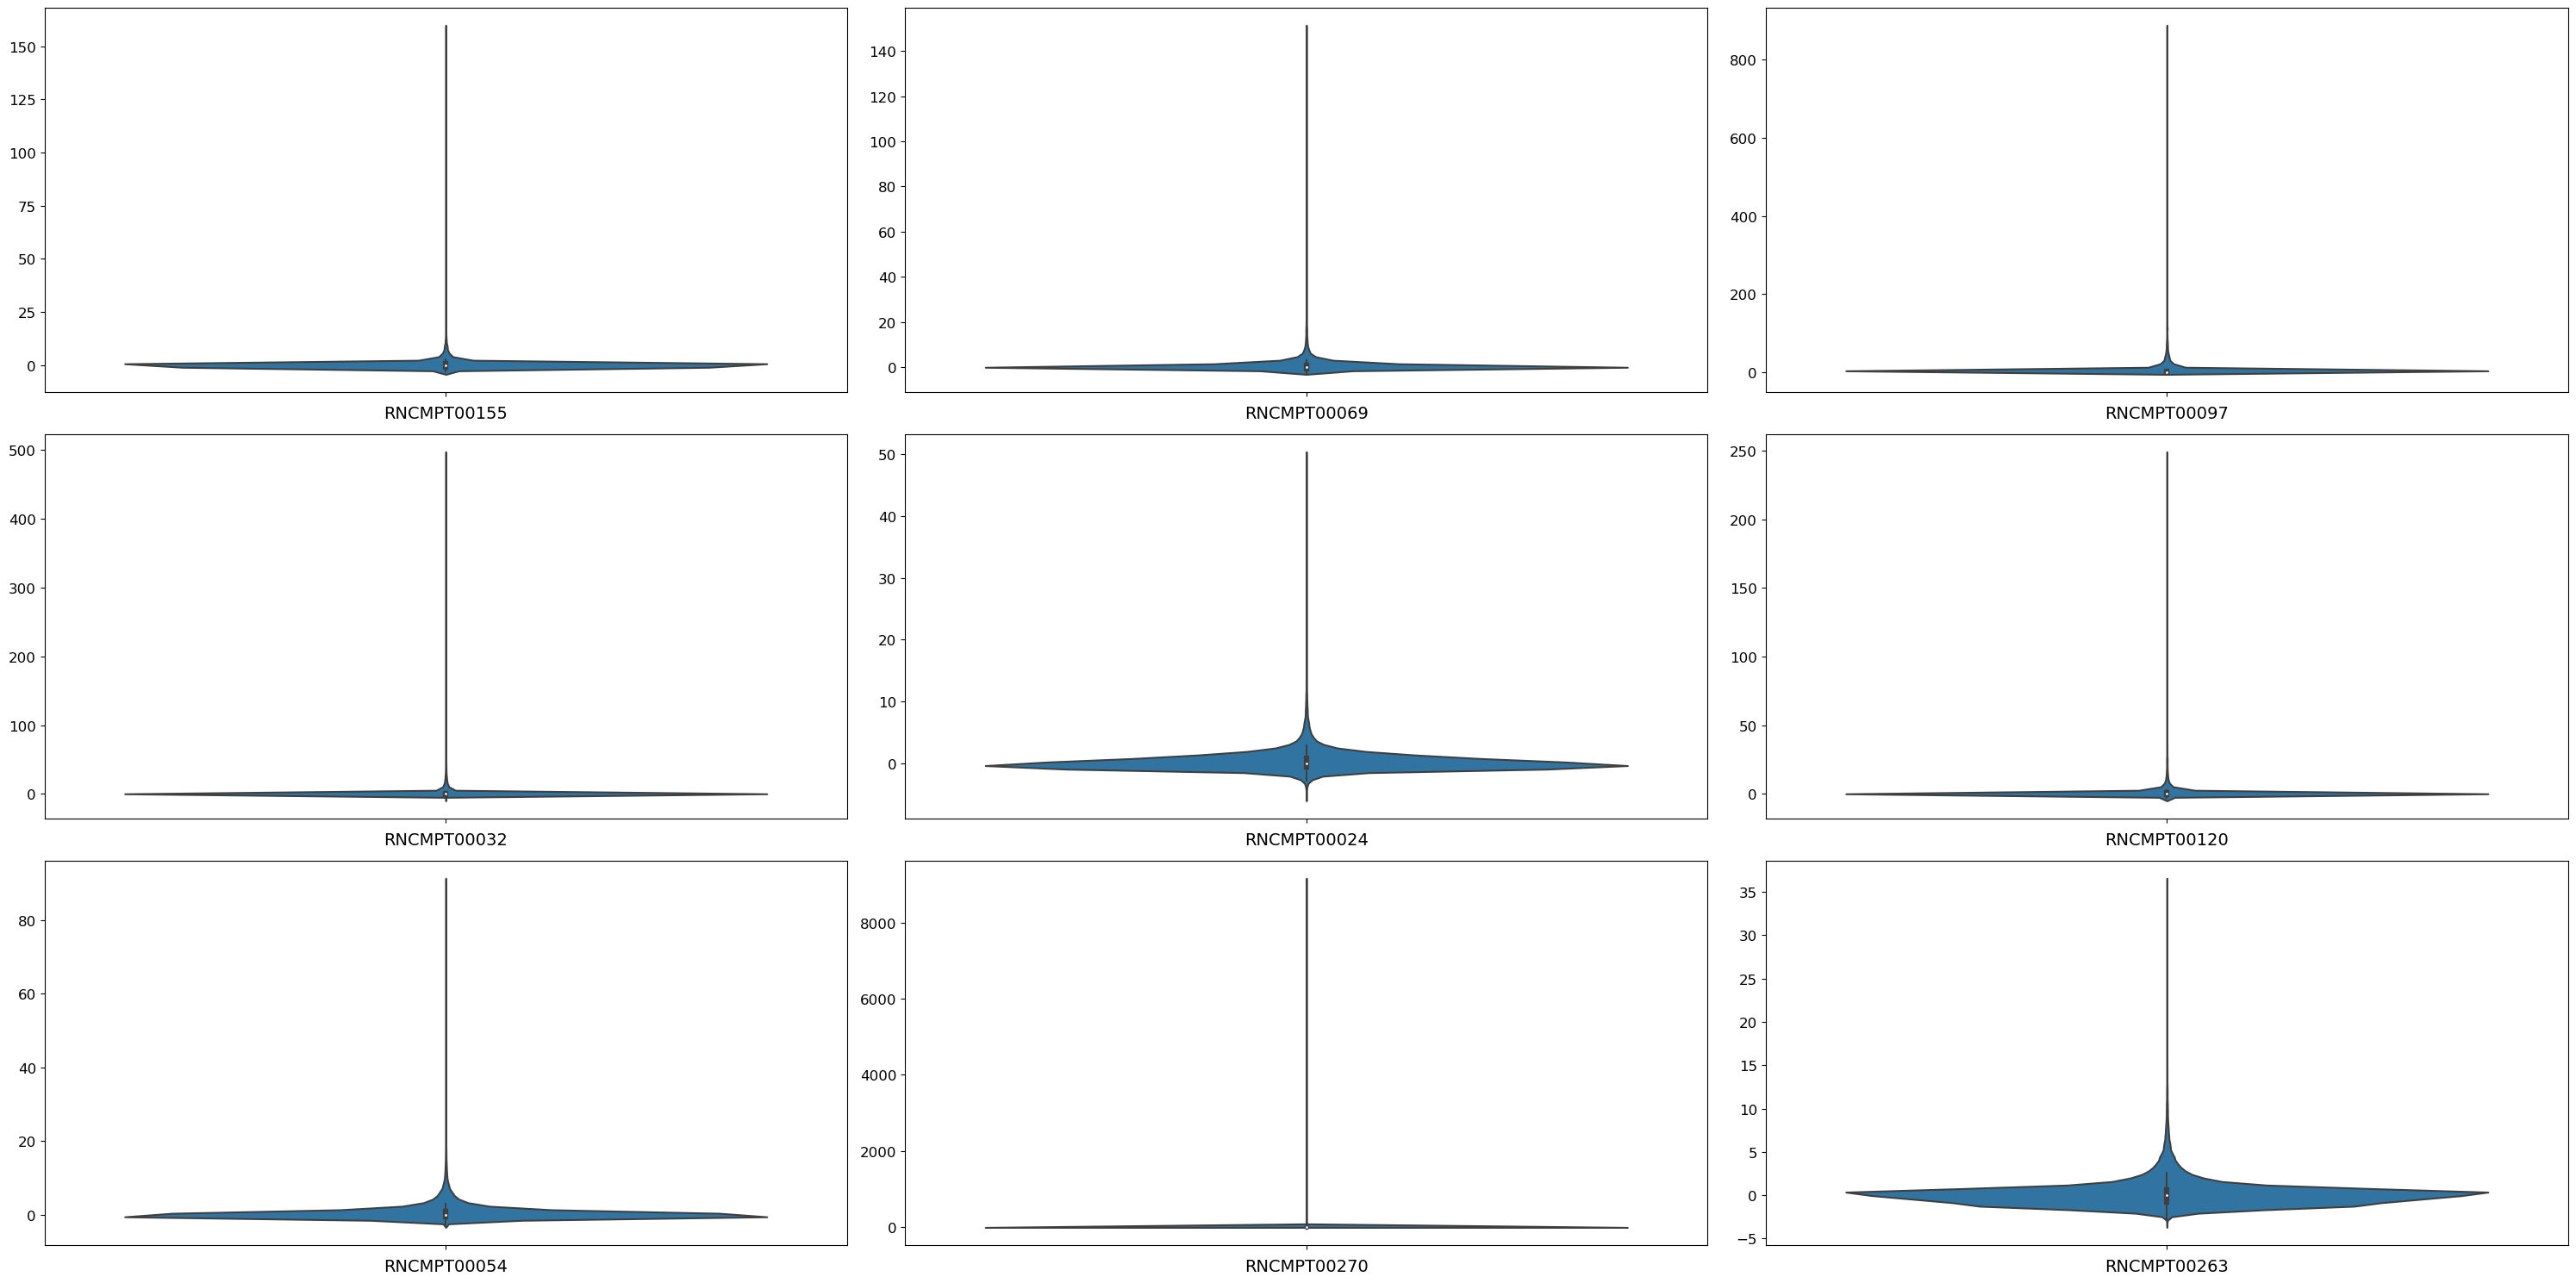

In [79]:
# Plot the distribution of the targets
pl.violinplot(
    sdata_setA, 
    keys=random_cols
)
plt.show()

In [80]:
# Clamp the targets based on percentiles
pp.clamp_targets_sdata(sdata_setA, target_keys=target_cols, percentile=0.9995, train_key="train_val", store_clamp_nums=True)

In [81]:
# Check the distribution of the clamped targets
sdata_setA[random_cols].to_dataframe().describe()

,RNCMPT00155,RNCMPT00069,RNCMPT00097,RNCMPT00032,RNCMPT00024,RNCMPT00120,RNCMPT00054,RNCMPT00270,RNCMPT00263
count,119714.000000,120322.000000,118832.000000,120324.000000,119707.000000,120135.000000,119721.000000,119755.000000,120303.000000
mean,0.104728,0.587801,1.251885,1.162649,0.282900,0.528732,0.444850,0.234518,0.123422
std,1.488171,3.068940,7.430682,6.931777,1.490316,3.566232,2.015113,1.506864,1.489037
min,-3.972950,-2.603297,-4.058324,-8.685942,-5.718174,-4.282501,-3.062826,-3.069384,-3.420699
25%,-0.721813,-0.583595,-0.523534,-0.631107,-0.585593,-0.642464,-0.590222,-0.576251,-0.761692
50%,0.002018,0.000110,-0.001750,0.003069,0.000210,0.000000,-0.000558,0.000000,-0.000195
75%,0.631201,0.842525,0.927136,0.802815,0.820352,0.745038,0.819317,0.828484,0.600131
max,17.246832,58.791405,167.361554,130.716224,16.036606,74.636375,25.620472,36.338645,16.868961


In [82]:
# Make sure they match up with stored values
sdata_setA["clamp_nums"][random_idxs]

<xarray.DataArray 'clamp_nums' (_targets: 9)>
array([ 17.24683206,  58.7914046 , 167.36155449, 130.71622449,
        16.03660578,  74.63637527,  25.62047217,  36.33864484,
        16.8689606 ])
Coordinates:
  * _targets  (_targets) object 'RNCMPT00155' 'RNCMPT00069' ... 'RNCMPT00263'

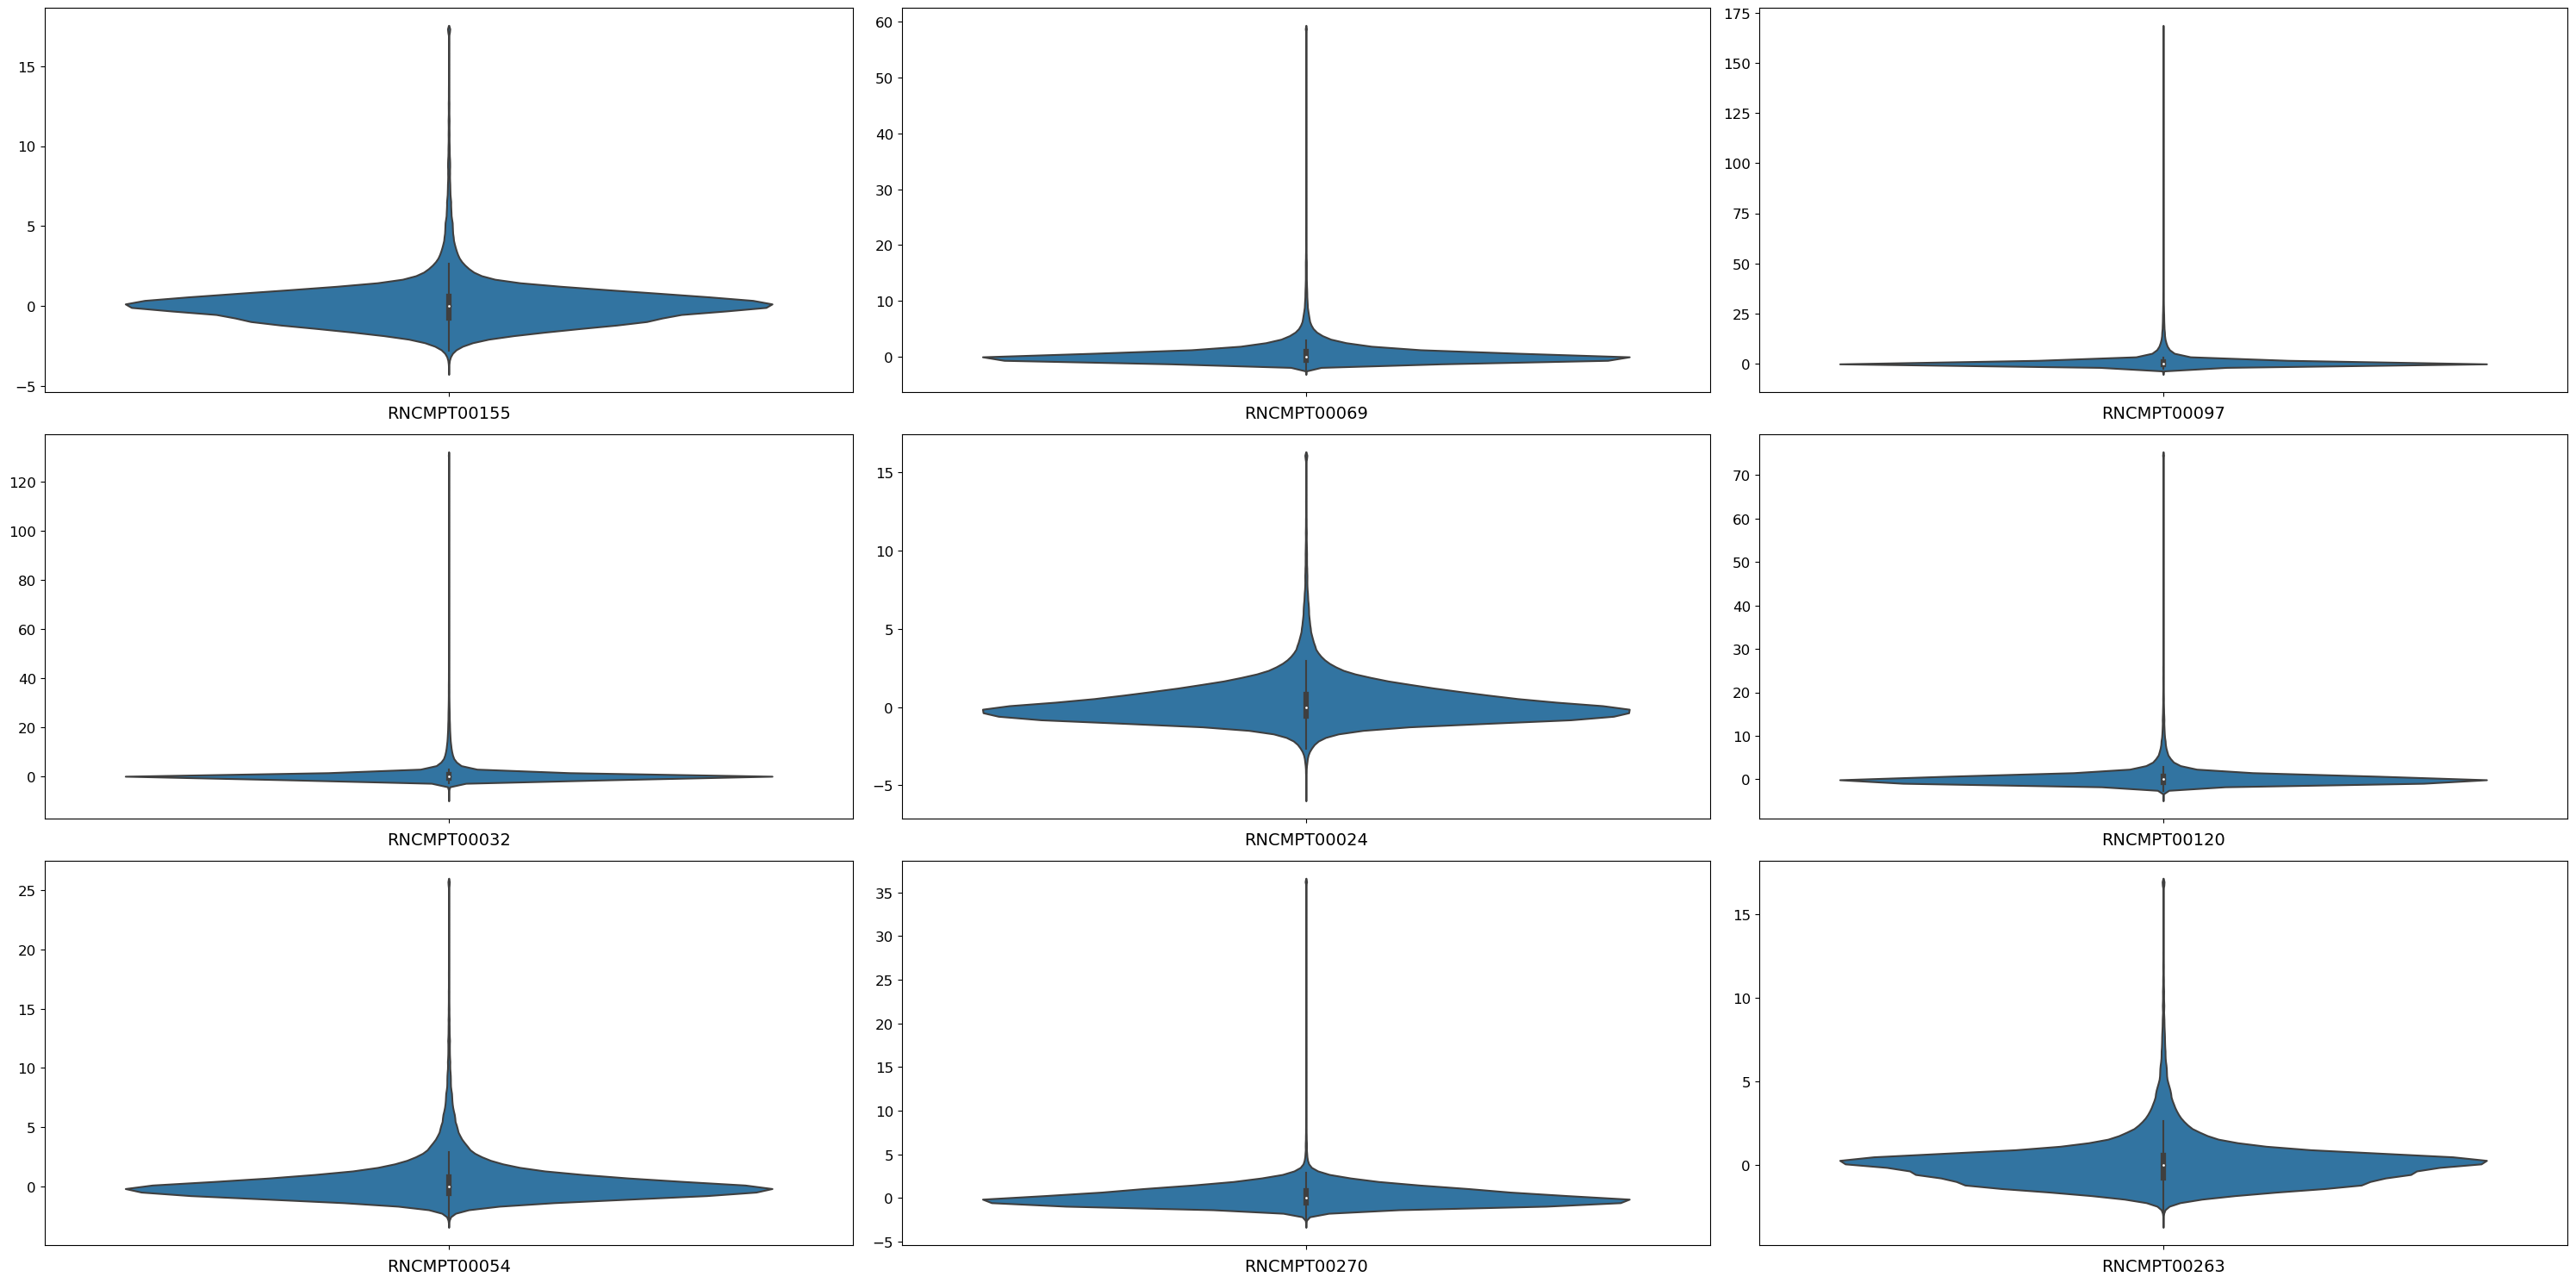

In [83]:
# Plot the distribution of the clamped targets
pl.violinplot(
    sdata_setA, 
    keys=random_cols
)
plt.show()

In [84]:
# Scale the targets have mean 0 and variance 1
scaler = pp.scale_targets_sdata(sdata_setA, target_keys=target_cols, train_key="train_val", return_scaler=True)

In [85]:
# Check the distribution of the scaled targets, should be approximately normal but not exactly
sdata_setA[random_cols].to_dataframe().describe()

,RNCMPT00155,RNCMPT00069,RNCMPT00097,RNCMPT00032,RNCMPT00024,RNCMPT00120,RNCMPT00054,RNCMPT00270,RNCMPT00263
count,119714.000000,120322.000000,118832.000000,120324.000000,119707.000000,120135.000000,119721.000000,119755.000000,120303.000000
mean,0.001617,-0.002877,-0.001018,-0.001492,0.001805,-0.002889,-0.002596,-0.002174,0.001470
std,1.009032,0.990918,0.991359,1.001375,1.001186,1.002517,1.000582,0.977275,0.998445
min,-2.763189,-1.033238,-0.709476,-1.424235,-4.029684,-1.355394,-1.744295,-2.144917,-2.374972
25%,-0.558806,-0.381105,-0.237884,-0.260620,-0.581644,-0.332129,-0.516550,-0.527998,-0.592026
50%,-0.068024,-0.192635,-0.168271,-0.169006,-0.188105,-0.151523,-0.223758,-0.154271,-0.081419
75%,0.358584,0.079370,-0.044344,-0.053474,0.362862,0.057917,0.183342,0.383041,0.321118
max,11.624557,18.790257,22.160394,18.714022,10.585060,20.829801,12.498087,23.413124,11.229867


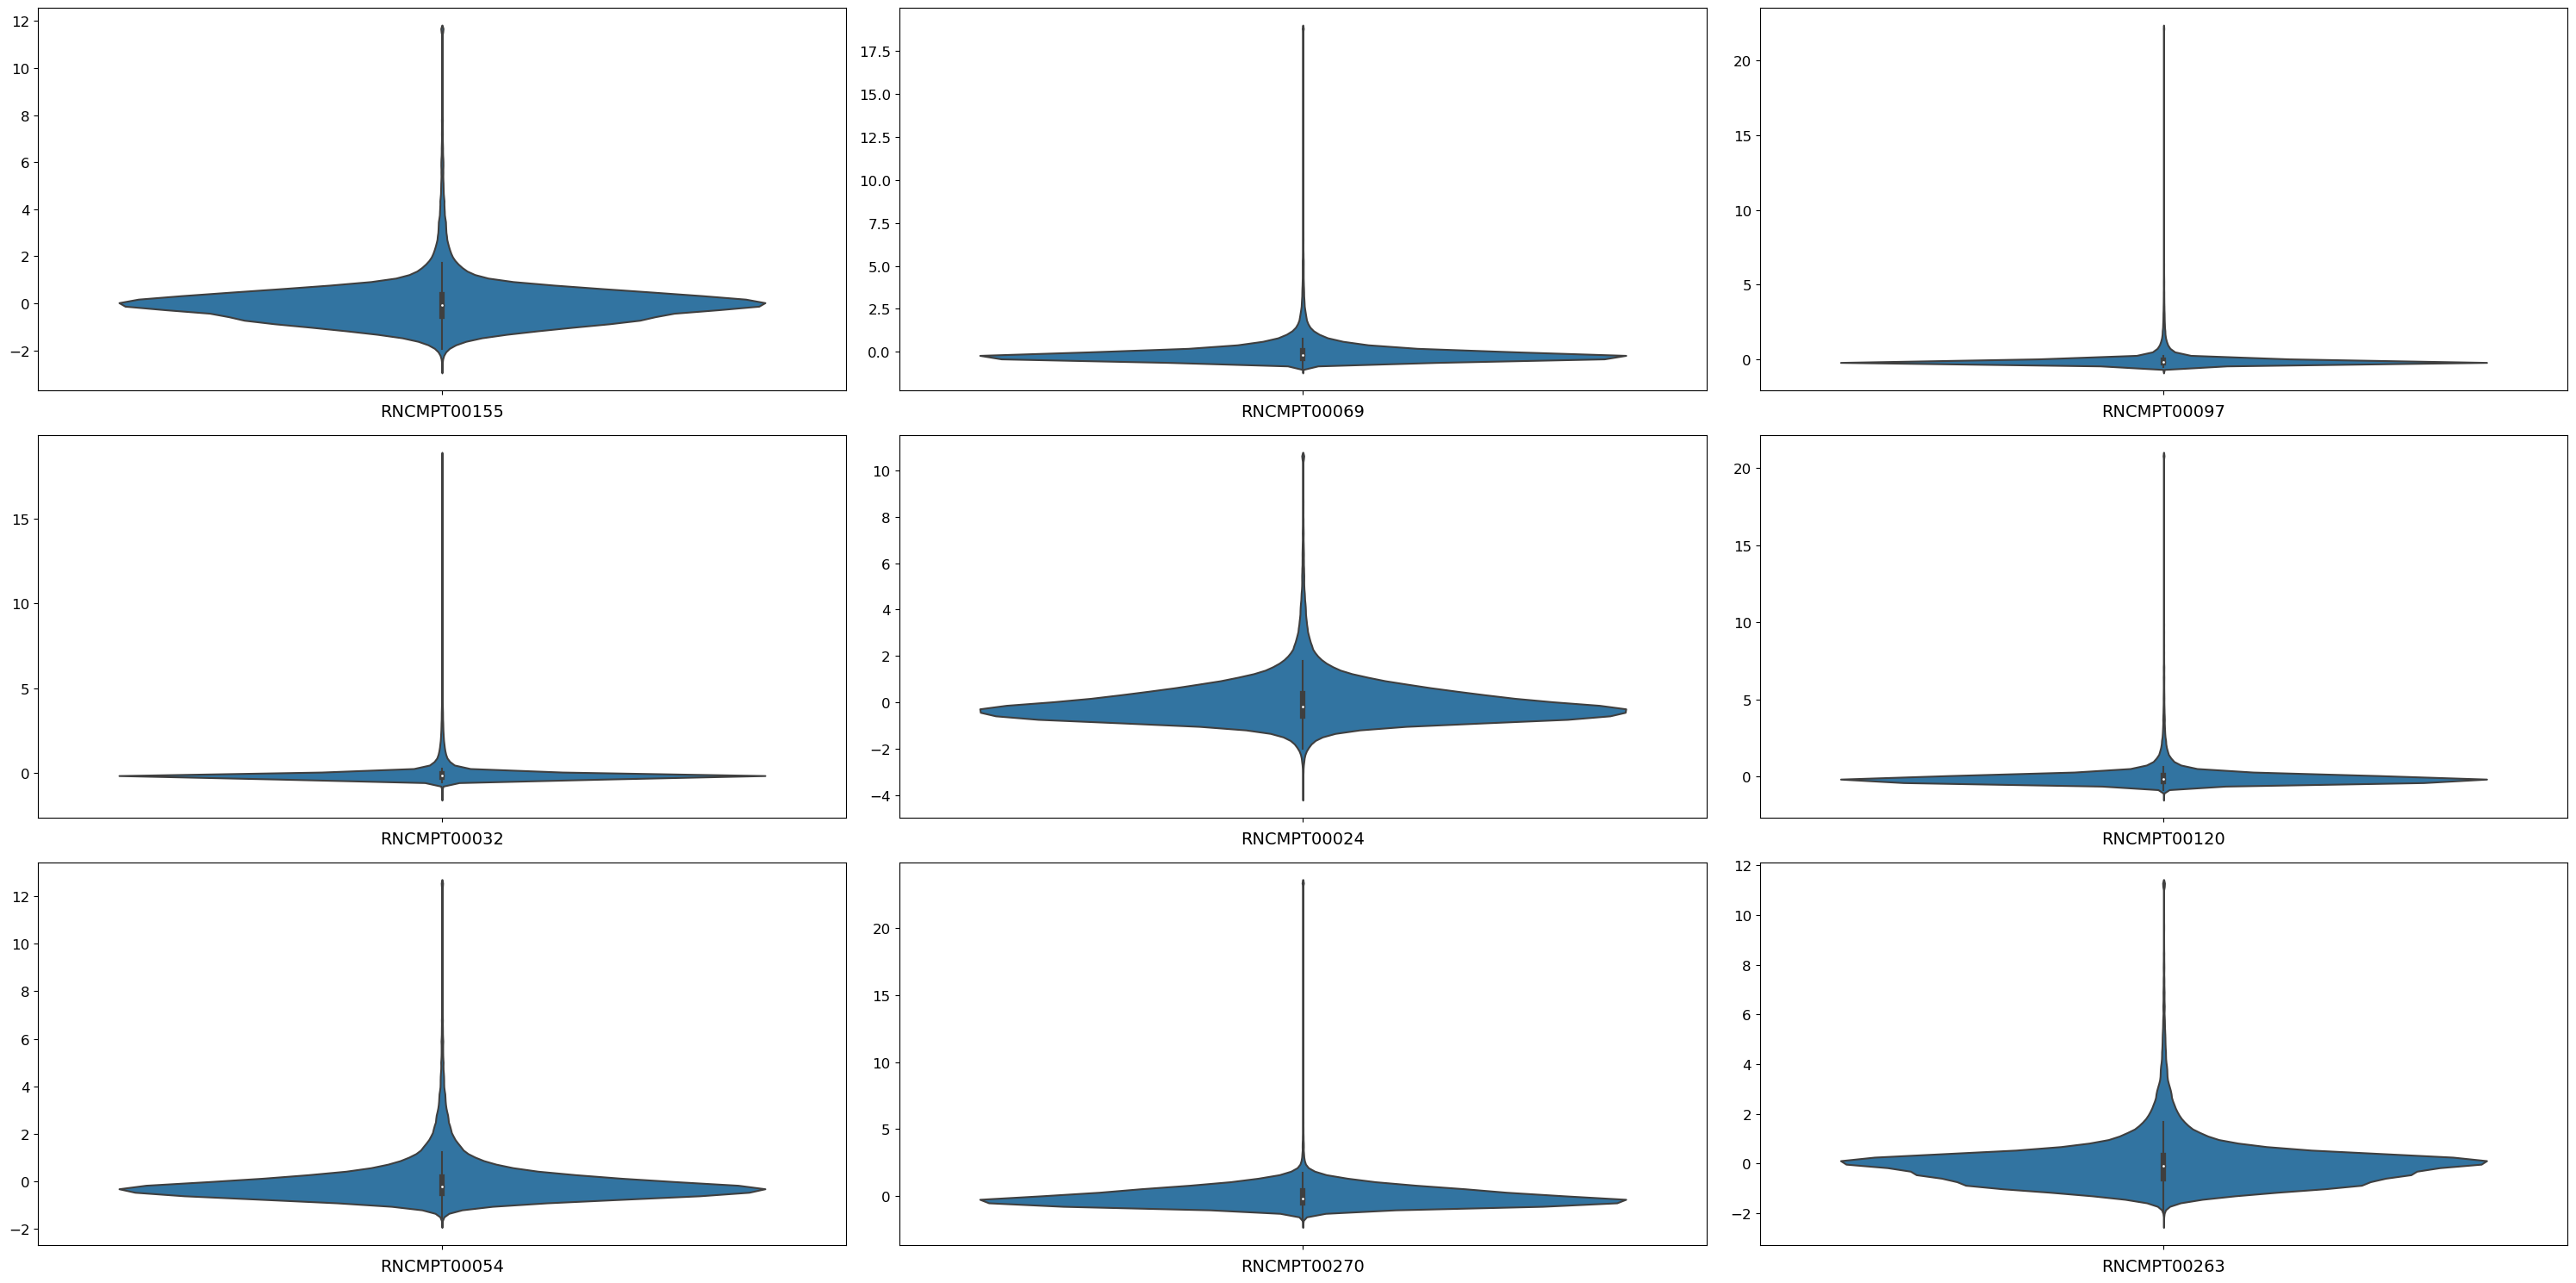

In [86]:
# Plot the distribution of the scaled targets
pl.violinplot(
    sdata_setA, 
    keys=random_cols
)
plt.show()

# Preprocess the test set
- We need to apply the clamping numbers from the training set to the test set.
- We need to apply the mean and standard deviation from the training set to the test set.

In [87]:
# Apply the same clamping to the test set
pp.clamp_targets_sdata(sdata_setB, target_keys=target_cols, clamp_nums=sdata_setA["clamp_nums"].to_series())

In [88]:
# Check the clamping
sdata_setB[random_cols].to_dataframe().describe()

,RNCMPT00155,RNCMPT00069,RNCMPT00097,RNCMPT00032,RNCMPT00024,RNCMPT00120,RNCMPT00054,RNCMPT00270,RNCMPT00263
count,120383.000000,121028.000000,119441.000000,121030.000000,120379.000000,120858.000000,120392.000000,120445.000000,121005.000000
mean,0.112481,0.582556,1.246400,1.154500,0.287555,0.544190,0.450571,0.240935,0.122428
std,1.531587,2.994819,7.151741,6.959434,1.486171,3.670558,2.021073,1.503091,1.490491
min,-4.029781,-2.755323,-4.675204,-9.871656,-4.874190,-3.823442,-3.272640,-2.974045,-3.127888
25%,-0.725805,-0.584001,-0.526375,-0.630686,-0.590369,-0.642464,-0.587128,-0.569583,-0.765361
50%,-0.002140,0.000046,0.002082,-0.003237,-0.000368,0.000000,0.000625,0.006047,-0.000031
75%,0.630078,0.838383,0.930152,0.801380,0.824793,0.757612,0.823461,0.828484,0.598238
max,17.246832,58.791405,167.361554,130.716224,16.036606,74.636375,25.620472,36.338645,16.868961


In [89]:
# Apply the same scaling to the test set
pp.scale_targets_sdata(sdata_setB, target_keys=target_cols, scaler=scaler, suffix=False, return_scaler=False)

In [90]:
# Check the scaling
sdata_setB[random_cols].to_dataframe().describe()

,RNCMPT00155,RNCMPT00069,RNCMPT00097,RNCMPT00032,RNCMPT00024,RNCMPT00120,RNCMPT00054,RNCMPT00270,RNCMPT00263
count,120383.000000,121028.000000,119441.000000,121030.000000,120379.000000,120858.000000,120392.000000,120445.000000,121005.000000
mean,0.006874,-0.004571,-0.001750,-0.002669,0.004932,0.001456,0.000245,0.001987,0.000804
std,1.038469,0.966985,0.954145,1.005371,0.998402,1.031845,1.003542,0.974828,0.999420
min,-2.801723,-1.082326,-0.791777,-1.595525,-3.462700,-1.226346,-1.848475,-2.083085,-2.178633
25%,-0.561513,-0.381236,-0.238263,-0.260560,-0.584853,-0.332129,-0.515014,-0.523674,-0.594486
50%,-0.070843,-0.192655,-0.167760,-0.169917,-0.188493,-0.151523,-0.223171,-0.150349,-0.081309
75%,0.357823,0.078032,-0.043942,-0.053681,0.365846,0.061452,0.185399,0.383041,0.319849
max,11.624557,18.790257,22.160394,18.714022,10.585060,20.829801,12.498087,23.413124,11.229867


In [91]:
# Take subset for testing, only for tests/use_cases/ray13
sdata_setA_sub = sdata_setA.isel(_sequence=slice(100))
sdata_setB_sub = sdata_setB.isel(_sequence=slice(100))

In [24]:
# Save the processed data
#sd.to_zarr(sdata_setA_sub, os.path.join(settings.dataset_dir, "ray13", "norm_setA_sub_ST.zarr"), load_first=True, mode="w")
#sd.to_zarr(sdata_setB_sub, os.path.join(settings.dataset_dir, "ray13", "norm_setB_sub_ST.zarr"), load_first=True, mode="w")
#sd.to_zarr(sdata_setA, os.path.join(settings.dataset_dir, "ray13", "norm_setA_ST.zarr"), load_first=True, mode="w")
#sd.to_zarr(sdata_setB, os.path.join(settings.dataset_dir, "ray13", "norm_setB_ST.zarr"), load_first=True, mode="w")

# Generate multitask ready data
 - With single task training, we can just filter out NaNs and train on the remaining data.
 - We can't do this for multitask training, so we need to generate a separate `SeqData` object where there are no NaNs.

In [92]:
# Get the columns that you would keep if you removed columns with a certain percentage of missing values
nan_cutoff = 0.01
nan_percents = sdata[target_cols].to_dataframe().isna().sum(axis=0).sort_values(ascending=False)/sdata.dims["_sequence"]
remove_cols = nan_percents[nan_percents > nan_cutoff].index
keep_cols = target_cols.drop(remove_cols)
len(keep_cols)

233

In [93]:
# Make a copy of the training data and subset it to only the columns with < nan_cutoff missing values
sdata_setA_MT = sdata_setA.copy()
sdata_setA_MT = sdata_setA_MT.drop(list(remove_cols) + ["_targets", "clamp_nums"])

In [94]:
# Get rid of any sequences that have missing values in the remaining target columns
keep_rows = np.where(sdata_setA_MT[keep_cols].to_dataframe().isna().sum(axis=1) == 0)[0]
sdata_setA_MT = sdata_setA_MT.isel(_sequence=keep_rows)

In [95]:
# We also need to remove the columns from the Set B object, but we don't need to remove any rows since we can just ignore those in the evaluation stage
sdata_setB_MT = sdata_setB.copy()
sdata_setB_MT = sdata_setB_MT.drop(list(remove_cols))

In [97]:
# Double check that the shapes make sense (Set A object has 2 extra columns, one set and one for train/val split. Set B object has 1 extra column, jus the set)
(sdata_setA_MT.dims["_sequence"], len(sdata_setA_MT.data_vars)), (sdata_setB_MT.dims["_sequence"], len(sdata_setB_MT.data_vars))

((110645, 238), (121031, 237))

In [98]:
# Check if copy worked
(sdata_setA.dims["_sequence"], len(sdata_setA.data_vars)), (sdata_setB.dims["_sequence"], len(sdata_setB.data_vars))

((120326, 250), (121031, 248))

In [99]:
# Doubke check that there are no missing values in the remaining columns
sdata_setA_MT[keep_cols].to_dataframe().isna().sum().sum()

0

In [100]:
# Take subset for testing
sdata_setA_MT_sub = sdata_setA_MT.isel(_sequence=slice(100))
sdata_setB_MT_sub = sdata_setB_MT.isel(_sequence=slice(100))

In [38]:
# Save the processed data
#sd.to_zarr(sdata_setA_MT_sub, os.path.join(settings.dataset_dir, "ray13", "norm_setA_sub_MT.zarr"), load_first=True, mode="w")
#sd.to_zarr(sdata_setB_MT_sub, os.path.join(settings.dataset_dir, "ray13", "norm_setB_sub_MT.zarr"), load_first=True, mode="w")
#sd.to_zarr(sdata_setA_MT, os.path.join(settings.dataset_dir, "ray13", "norm_setA_MT.zarr"), load_first=True, mode="w")
#sd.to_zarr(sdata_setB_MT, os.path.join(settings.dataset_dir, "ray13", "norm_setB_MT.zarr"), load_first=True, mode="w")

# Generating a presence/absence matrix per probe
- We need to generate a presence/absence matrix per probe to use for evaluation
    - This presence/absence matrix is a binary matrix where the rows are all possible k-mers and the columns are probes.
    - The value of a cell is 1 if the k-mer is present in that probe and 0 otherwise.

> **Note**
> Each one of these matrices takes about 15 minutes to generate!

In [101]:
# Helper function to generate a presence/absence matrix
from ray13_helpers import generate_all_possible_kmers, kmer_in_seqs

In [102]:
# Generate all possible 7-mers and check
a_probes = pd.Series(sdata_setA["seq"].to_series())
a_probes_MT = pd.Series(sdata_setA_MT["seq"].to_series())
b_probes = pd.Series(sdata_setB["seq"].to_series())
kmers = generate_all_possible_kmers(n=7, alphabet="ACGU")
len(a_probes), len(a_probes_MT), len(b_probes), len(kmers)

(120326, 110645, 121031, 16384)

In [ ]:
# Generate the Set A presence/absence matrix
a_hits = np.array([a_probes.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "setA_binary_ST"), a_hits)
a_hits.shape, np.all((a_hits == 1).sum(axis=1) >= 155)

In [ ]:
# Generate the Set A presence/absence matrix
a_hits_MT = np.array([a_probes_MT.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "setA_binary_MT"), a_hits)
a_hits_MT.shape, np.all((a_hits_MT == 1).sum(axis=1) >= 155)

In [ ]:
# Generate the Set B presence/absence matrix
b_hits = np.array([b_probes.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "setB_binary"), b_hits)
b_hits.shape,  np.all((b_hits == 1).sum(axis=1) >= 155)

# DONE!

---

# Scratch

In [103]:
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/ray13"

In [104]:
for zarr in ["norm_setA_sub_MT.zarr", "norm_setB_sub_MT.zarr", "norm_setA_MT.zarr", "norm_setB_MT.zarr"]:
    sdata = sd.open_zarr(os.path.join(settings.dataset_dir, zarr))
    print(zarr, sdata.dims["_sequence"], len(sdata.data_vars))
    if "train_val" in sdata.data_vars:
        print(np.unique(sdata["train_val"].values, return_counts=True))
    else:
        print("No train_val column found")

norm_setA_sub_MT.zarr 100 238
(array([False,  True]), array([20, 80]))
norm_setB_sub_MT.zarr 100 237
No train_val column found
norm_setA_MT.zarr 110645 238
(array([False,  True]), array([22200, 88445]))
norm_setB_MT.zarr 121031 237
No train_val column found


In [105]:
for zarr in ["norm_setA_sub_ST.zarr", "norm_setB_sub_ST.zarr", "norm_setA_ST.zarr", "norm_setB_ST.zarr"]:
    sdata = sd.open_zarr(os.path.join(settings.dataset_dir, zarr))
    print(zarr, sdata.dims["_sequence"], len(sdata.data_vars))
    if "train_val" in sdata.data_vars:
        print(np.unique(sdata["train_val"].values, return_counts=True))
    else:
        print("No train_val column found")

norm_setA_sub_ST.zarr 100 250
(array([False,  True]), array([21, 79]))
norm_setB_sub_ST.zarr 100 248
No train_val column found
norm_setA_ST.zarr 120326 250
(array([False,  True]), array([24066, 96260]))
norm_setB_ST.zarr 121031 248
No train_val column found
